In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add code directory to path
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), 'code'))

In [3]:
import json

In [10]:
variant = "fl1_12"
with open(f"/home/labs/fleishman/omripo/AF3/NNMT/af3_inference_output/3-Methyl-4-phenylpyrazol_SAM/{variant}/{variant}_confidences.json", "r") as f:
    data = json.load(f)


In [11]:
data["atom_plddts"][237:248]

[75.13, 69.87, 69.94, 61.62, 67.23, 62.98, 63.6, 58.6, 55.25, 50.97, 67.63]

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from config import load_config

In [7]:
config = load_config("configs/config_original_paper.yaml")
sequences_df = pd.read_csv(config["dataset_path"])

Loaded configuration:
  root_path: /home/labs/fleishman/omripo/Projects/adaptive_learning
  data_dir_name: data
  pretraining_dir_name: pretraining
  bootstrap_dir_name: bootstrap
  results_dir_name: results
  enzyme: PTE
  substrate: malathion
  dataset_filename: llm_input_original_paper.csv
  tag: original_paper
  weights_filename: final_model.pt
  model_type: plm
  finetune: False
  opmode: mean
  train_type: msa_backbone
  nmuts_column: num_muts
  sequence_column_name: full_seq
  activity_column_name: inactive
  first_column_name: I106
  last_column_name: M317
  plm_name: esm2_t12_35M_UR50D
  ref_seq: DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDIGRDVSLLAEVSRAADVHIVAATGLWFDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKATPFQELVLKAAARASLATGVPVTTHTAASQRDGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDRVNPDGMAFIPLRVIPFLREKGVPQETLAGITVTNPARFLSPTLRAS
  bootstrap_indices_prefix: indices
  train_indices: al

In [8]:
substrates = ["CMP", "EMP", "IMP", "malathion", "naphthyl_acetate", "nonanoic_lactone", "p-nitrophenyl_acetate",
              "p-nitrophenyl_octanoate", "paraoxon", "PMP", "TBBL"]

In [18]:

for substrate in substrates:
    substrate_dataset_path = os.path.join(config["data_dir_path"], substrate, config["dataset_filename"])
    df = pd.read_csv(substrate_dataset_path)
    df = df[df["design"] != -1]
    print(f"{substrate}: {len(df)} sequences")
    # sort by design
    df = df.sort_values(by="design")
    df.to_csv(os.path.join(config["data_dir_path"], substrate, "tested_variants.csv"), index=False)

CMP: 50 sequences
EMP: 50 sequences
IMP: 50 sequences
malathion: 50 sequences
naphthyl_acetate: 50 sequences
nonanoic_lactone: 50 sequences
p-nitrophenyl_acetate: 50 sequences
p-nitrophenyl_octanoate: 50 sequences
paraoxon: 50 sequences
PMP: 50 sequences
TBBL: 50 sequences


In [21]:
main_df = pd.read_csv(config["dataset_path"])
main_df = main_df[main_df["design"] != -1]
main_df = main_df.sort_values(by="design")
main_df["activity"] = 0
main_df["inactive"] = 0
main_df.to_csv(os.path.join(config["data_dir_path"], "tested_variants.csv"), index=False)

In [11]:
sequences_df[["design", "full_seq"]].to_csv("/home/labs/fleishman/omripo/AF3/NNMT/sequences.csv", index=False)

In [14]:
# take the columns named 1 to 272 from sequences_df
positions = [str(i) for i in range(1, 273) if str(i) not in ['18', '32', '165', '195', '240']]
sequences_df[positions]
# find vocabulary per position
vocab_df = sequences_df[positions].nunique()
vocab_df[vocab_df > 1].index.tolist()

['20',
 '24',
 '34',
 '37',
 '167',
 '176',
 '197',
 '198',
 '199',
 '201',
 '204',
 '213',
 '242',
 '247',
 '248',
 '249',
 '252',
 '253']

In [49]:
embeddings = np.load(config["embeddings_path"])

In [52]:
# get first row of embeddings
wt_embedding = embeddings[0]
delta_embeddings = embeddings - wt_embedding

In [53]:
delta_embeddings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09375674, -0.05974418,  0.15780827, ..., -0.15276848,
         0.14678136, -0.02669254],
       [ 0.0727025 , -0.07149224,  0.14733857, ..., -0.14145811,
         0.12704703, -0.03696546],
       ...,
       [ 0.08654761, -0.06189558,  0.14485143, ...,  0.02377667,
         0.00682154, -0.00109723],
       [ 0.07862677, -0.06118868,  0.14550729, ...,  0.02116714,
         0.14284194,  0.00956637],
       [ 0.08042194, -0.06409391,  0.14411789, ...,  0.01977731,
         0.14944139,  0.00612119]], shape=(7880, 3840), dtype=float32)

In [41]:
# get distances between all pairs of embeddings
from scipy.spatial.distance import pdist, squareform, cdist


In [26]:
distances = squareform(pdist(delta_embeddings, metric='cosine'))

In [27]:
# print distances of pairs and state wihch pairs they are
for i in range(distances.shape[0]):
    for j in range(i+1, distances.shape[1]):
        print(f"Distance between sequence {i} and sequence {j}: {distances[i, j]}")

Distance between sequence 0 and sequence 1: nan
Distance between sequence 0 and sequence 2: nan
Distance between sequence 0 and sequence 3: nan
Distance between sequence 0 and sequence 4: nan
Distance between sequence 1 and sequence 2: 0.44278917689382136
Distance between sequence 1 and sequence 3: 0.3984467463935343
Distance between sequence 1 and sequence 4: 0.6800789529281099
Distance between sequence 2 and sequence 3: 0.4930931079277322
Distance between sequence 2 and sequence 4: 0.7193791186826723
Distance between sequence 3 and sequence 4: 0.7440472693048665


In [36]:
from itertools import combinations

In [43]:
sequences_df

,I106,F132,H254,H257,L271,L303,F306,M317,num_muts,full_seq,inactive,pad_regions,serial_number
0,I,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101
1,V,Y,R,H,L,A,M,M,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,303090101020301
2,I,Y,T,H,L,A,M,M,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,103110101020301
3,I,Y,M,H,L,A,M,M,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,103060101020301
4,V,Y,T,H,L,A,M,M,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,303110101020301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7875,I,H,Y,H,F,A,N,M,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,102120102020401
7876,V,H,T,H,Y,S,F,M,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,302110103050101
7877,M,F,T,H,F,L,V,M,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,201110102010501
7878,M,F,S,H,F,T,F,M,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,201100102060101


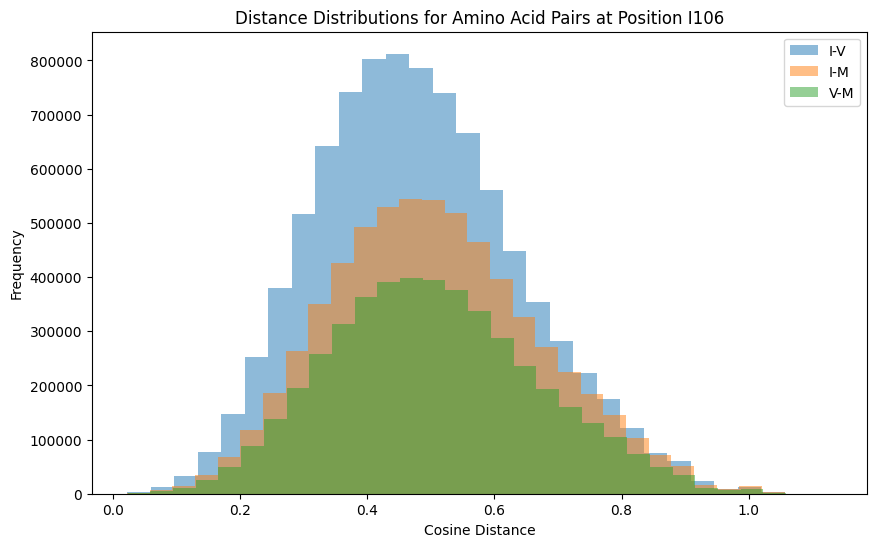

In [54]:
position = "I106"
AA_in_position = sequences_df[position].unique().tolist()
AA_pairs_in_position = list(combinations(AA_in_position, 2))

plt.figure(figsize=(10, 6))

for aa1, aa2 in AA_pairs_in_position:
    embeddings_aa1 = embeddings[sequences_df[position] == aa1]
    embeddings_aa2 = embeddings[sequences_df[position] == aa2]
    delta_embeddings_aa1 = embeddings_aa1 - wt_embedding
    delta_embeddings_aa2 = embeddings_aa2 - wt_embedding
    distances = cdist(delta_embeddings_aa1, delta_embeddings_aa2, metric='cosine')
    plt.hist(distances.flatten(), bins=30, alpha=0.5, label=f"{aa1}-{aa2}")

plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.title(f"Distance Distributions for Amino Acid Pairs at Position {position}")
plt.legend()
plt.show()


In [40]:
AA_pairs_in_position

[('I', 'V'), ('I', 'M'), ('V', 'M')]